In [1]:
import json
from haralyzer import HarParser, HarPage
import pandas as pd
import matplotlib as plt
from datetime import datetime

# Extract websocket data from Har to JSON

In [2]:
with open('10.2.8.177.har', 'r') as f:
    har_parser = HarParser(json.loads(f.read()))

data = har_parser.har_data
ws_entries = []
entries = []
dict_data = {}
for entry in har_parser.har_data["entries"]:
    if '_webSocketMessages' in entry.keys():
        ws_entries = entry['_webSocketMessages']
        break

for ws_entry in ws_entries:    
    if ws_entry['data'].startswith("{"):
        data = json.loads(ws_entry['data'])
        if data['type'] == 3:
            ws_entry['data'] = data
            entries.append(ws_entry)
dict_data['WS'] = entries
filename = "data_" + datetime.now().strftime("%m-%d-%Y_%H:%M:%S") + ".json"
with open(filename, 'w') as fp:
    json.dump(dict_data, fp)

# Read JSON and Process

In [3]:
df = pd.read_json(filename)
time = []
duration = []
for idx,row in df.iterrows():
    time.append(row['WS']['time'])
    durms = round(row['WS']['data']['data']['duration']/1000,2)
    duration.append(durms)
df['DateTime'] = time
df['TSDuration(ms)'] = duration
df['DateTime'] = pd.to_datetime(df['DateTime'],unit='s')
df.sort_values(by='DateTime')

WS  \
0      {'type': 'receive', 'time': 1617144468.528889,...   
1      {'type': 'receive', 'time': 1617144468.541831,...   
2      {'type': 'receive', 'time': 1617144468.547897,...   
3      {'type': 'receive', 'time': 1617144468.559335,...   
4      {'type': 'receive', 'time': 1617144468.56724, ...   
...                                                  ...   
60547  {'type': 'receive', 'time': 1617145869.5874739...   
60548  {'type': 'receive', 'time': 1617145869.595087,...   
60549  {'type': 'receive', 'time': 1617145869.599314,...   
60550  {'type': 'receive', 'time': 1617145869.7875519...   
60551  {'type': 'receive', 'time': 1617145869.793243,...   

                           DateTime  TSDuration(ms)  
0     2021-03-30 22:47:48.528888940           42.78  
1     2021-03-30 22:47:48.541831017            2.44  
2     2021-03-30 22:47:48.547897100            9.47  
3     2021-03-30 22:47:48.559334993            4.47  
4     2021-03-30 22:47:48.567240000            3.34  
...                             ...             ...  
60547 2021-03-30 23:11:09.587473869            8.56  
60548 2021-03-30 23:11:09.595087051            7.21  
60549 2021-03-30 23:11:09.599313974            7.46  
60550 2021-03-30 23:11:09.787551880           49.69  
60551 2021-03-30 23:11:09.793242931            2.65  

[60552 rows x 3 columns]

       TSDuration(ms)
count    60552.000000
mean        10.395011
std        237.259258
min          0.270000
25%          3.820000
50%          6.020000
75%          8.580000
max      48639.670000


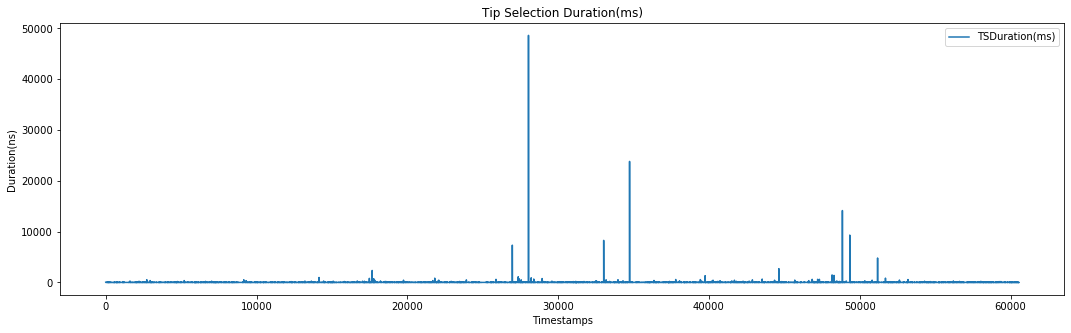

In [4]:
plot = df[['TSDuration(ms)']].plot(figsize=(18,5),title='Tip Selection Duration(ms)',xlabel='Timestamps',ylabel='Duration(ns)')
plot.plot(df['TSDuration(ms)'].mean(),'r')
fig = plot.get_figure()
fig.savefig("output.png")
print(df.describe())
fig.show()

In [5]:
df.describe()

TSDuration(ms)
count    60552.000000
mean        10.395011
std        237.259258
min          0.270000
25%          3.820000
50%          6.020000
75%          8.580000
max      48639.670000

In [60]:
# 10 * 100
df.describe()

TSDuration(ns)
count     1115.000000
mean      3398.074439
std       5718.106911
min        140.000000
25%       1115.000000
50%       2388.000000
75%       4473.000000
max     133215.000000

In [66]:
# 20 * 100
df.describe()

TSDuration(ns)
count     3580.000000
mean      3648.198324
std       7090.446203
min        178.000000
25%       1302.250000
50%       2563.000000
75%       4339.250000
max     220496.000000

In [85]:
# 20 * 100
df.describe()

TSDuration(ns)
count     4210.000000
mean      4048.725416
std       7875.605632
min        122.000000
25%       1419.250000
50%       2774.500000
75%       4721.500000
max     270249.000000

In [78]:
# 40 * 100
df.describe()

TSDuration(ns)
count     7989.000000
mean      4069.465765
std      11917.567549
min        151.000000
25%       1450.000000
50%       2794.000000
75%       4610.000000
max     588722.000000

In [81]:
# 40 * 100 cache emptied
df.describe()

TSDuration(ns)
count     8251.000000
mean      3860.570113
std       7722.214896
min        200.000000
25%       1382.000000
50%       2776.000000
75%       4650.000000
max     273372.000000

# Process locust perf data

In [68]:
import matplotlib.pyplot as plt 

def plotER(df,sheet_name):   
    fig=plt.figure()

    ax1 = df[['Total Average Response Time']].plot(marker='*',legend=False)
    ax2 = df['Requests/s'].plot(secondary_y=True, marker='o')
    ax1.set_ylabel('Mean Response Time(ms)')
    ax2.set_ylabel('Requests/s')

    handles,labels = [],['E[R]','$\lambda$']
    for ax in [ax1,ax2]:
        for h,_ in zip(*ax.get_legend_handles_labels()):
            handles.append(h)

    plt.legend(handles,labels,loc='upper left')

    plt.title('Mean Response Time against User Count ({})'.format(sheet_name))
    plt.show()

def load(sheet_name):
    """
    load data and return statistics.
    
    Parameters:
        sheet_name: string
        One of the sheet names ['prepareTransfer', 'sendTrytes','sendTransfer', 'ts', 'pow', 'bc']
    """
    sendTran = pd.read_excel('data/locustdata.xlsx', sheet_name=sheet_name)
    sendTran = sendTran.loc[(sendTran['User Count'] % 10 == 0)]
    sticsendTran = sendTran.groupby(by='User Count').mean()
    return sticsendTran

<Figure size 432x288 with 0 Axes>

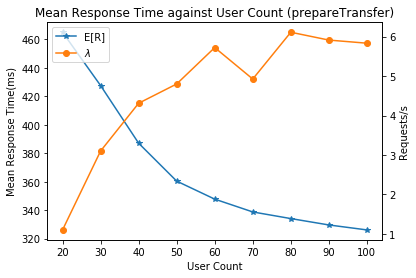

<Figure size 432x288 with 0 Axes>

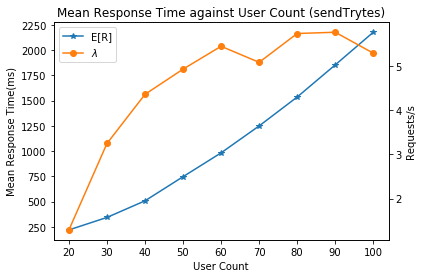

<Figure size 432x288 with 0 Axes>

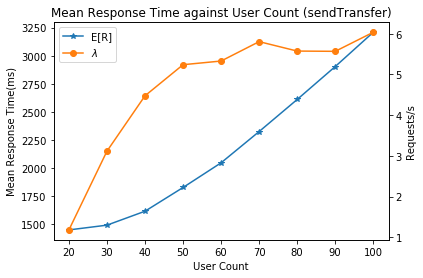

<Figure size 432x288 with 0 Axes>

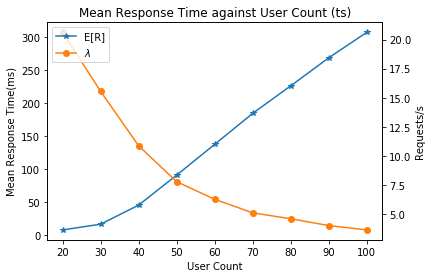

<Figure size 432x288 with 0 Axes>

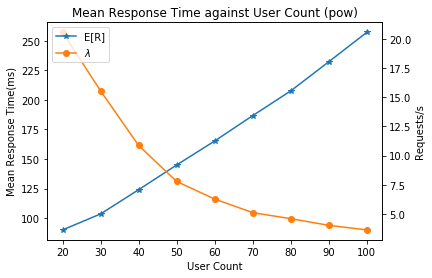

<Figure size 432x288 with 0 Axes>

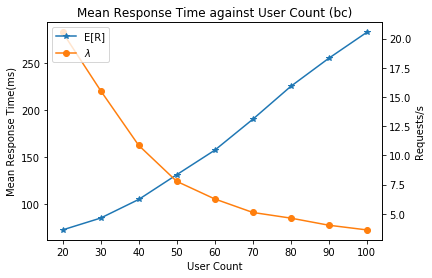

In [69]:
tasks = ['prepareTransfer', 'sendTrytes','sendTransfer', 'ts', 'pow', 'bc']
for sheet_name in tasks:
    df = load(sheet_name)
    plotER(df,sheet_name)